In [83]:
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from PIL import Image
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

from subprocess import check_output

from keras_tqdm import TQDMNotebookCallback
import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Flatten,Activation,Conv2D,MaxPooling2D,Flatten
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback

from scipy import ndimage
import cv2 
import os
import shutil

%matplotlib inline

In [ ]:
###TESTTTT

In [19]:
train_images = glob("./train/*jpg")
test_images = glob("./test/*jpg")
df = pd.read_csv("./train.csv")

#df["Image"] = df["Image"].map( lambda x : "./train/"+x)
#ImageToLabelDict = dict( zip( df["Image"], df["Id"]))

In [25]:
train_images[0]

'./train/18fadb00.jpg'

In [20]:
num_classes=df['Id'].nunique()
print(num_classes)

4251


In [32]:
le = LabelEncoder()
df["Lables"]=le.fit_transform(df["Id"])
lables=df.Lables
y_train=to_categorical(df["Lables"], num_classes=num_classes)

In [69]:
path = "./train/"
                   
def categorize_image_class(path_to_train_imgs):

    for c in set(lables): 
        os.makedirs('./train/{0}/'.format(c))
    df = pd.read_csv("./train.csv")
    le = LabelEncoder()
    df["Lables"]=le.fit_transform(df["Id"])
    
    file_names = [f for f in os.listdir(path_to_train_imgs)
                 if f.endswith(".jpg")]
    
    for f in file_names: 
        shutil.move(os.path.join(path_to_train_imgs,f), 
                        os.path.join(path_to_train_imgs, str(df[df["Image"] == f]['Lables'].iloc[0])))
            
categorize_image_class(path)

In [73]:
test=ndimage.imread("./train/1/78ea29eb.jpg",mode="RGB")
test2=cv2.imread("./train/1/78ea29eb.jpg")

In [86]:
w_size=[]
L_size=[]
def SizeImage( filename):
    img = ndimage.imread(filename,mode="RGB")
    w_size.append(img.shape[0])
    L_size.append(img.shape[1])
    return w_size,L_size
#train_sizes =[SizeImage( img) for img in train_images]

(64, 64, 3)

In [60]:
min(w_size),max(w_size),min(L_size),max(L_size)

(30, 1613, 64, 1050)

In [11]:
size1=64
size2=64

X_data=[]

for myFile in train_images:
    image = cv2.imread(myFile)
    #image=image.resize((size1,size2,3))
    X_data.append(image)
    
X_data_array=np.array(X_data)

print('X_data shape:', X_data_array.shape)

X_data shape: (9850,)


In [80]:
batch_size=32

datagen = ImageDataGenerator(rescale=1./255
    #rotation_range=20,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #horizontal_flip=True
)

train_generator = datagen.flow_from_directory("train/",target_size=(64, 64),batch_size=batch_size,class_mode='categorical')

Found 9850 images belonging to 4251 classes.


In [81]:
model = Sequential()
model.add(Conv2D(32,(3,3),padding='same',input_shape=(64, 64, 3)))
model.add(Activation('relu'))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(64,(3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 31, 31, 64)        18496     
__________

In [82]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
history = LossHistory()

## Callback for early stopping the training
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

In [85]:
epochs = 10

fitted_model = model.fit_generator(
        train_generator,
        steps_per_epoch= int(train_generator.n/train_generator.batch_size),
        epochs=epochs,
        callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True), early_stopping, history],verbose=0)

HBox(children=(IntProgress(value=0, description='Training', max=10), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=307), HTML(value='')))

/Users/parisarezaie/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:497: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


HBox(children=(IntProgress(value=0, description='Epoch 1', max=307), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=307), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=307), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=307), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=307), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=307), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=307), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=307), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=307), HTML(value='')))

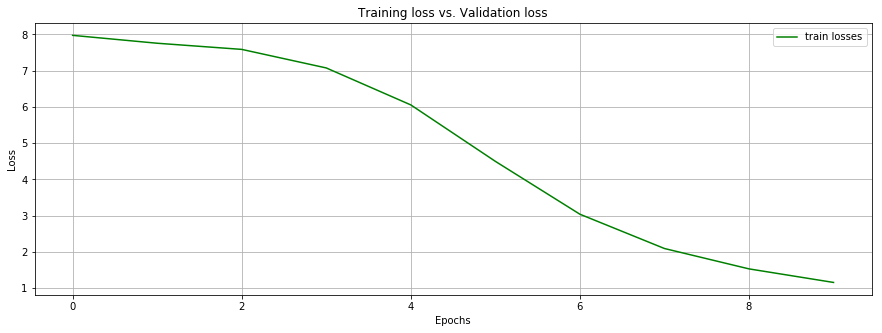

In [87]:
losses, val_losses = history.losses, history.val_losses
fig = plt.figure(figsize=(15, 5))
plt.plot(fitted_model.history['loss'], 'g', label="train losses")
#plt.plot(fitted_model.history['val_loss'], 'r', label="val losses")
plt.grid(True)
plt.title('Training loss vs. Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

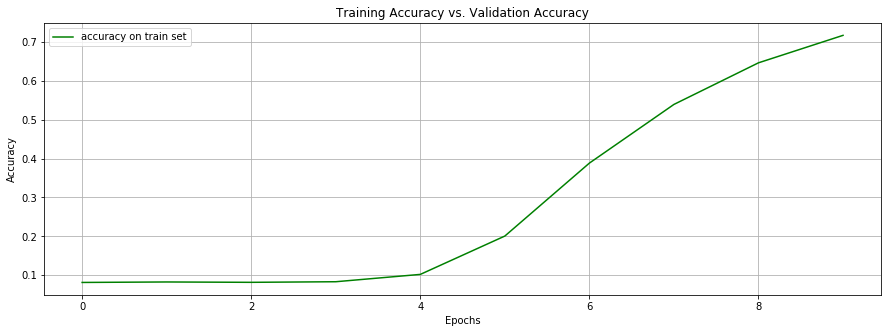

In [88]:
losses, val_losses = history.losses, history.val_losses
fig = plt.figure(figsize=(15, 5))
plt.plot(fitted_model.history['acc'], 'g', label="accuracy on train set")
#plt.plot(fitted_model.history['val_acc'], 'r', label="accuracy on validation set")
plt.grid(True)
plt.title('Training Accuracy vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()